In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyomo.environ as pyo
import matplotlib.dates as mdates
from load_data_PLD import get_load_data, get_gen_data, get_spot_prices_data
from scipy.interpolate import make_interp_spline
import datetime as dt

AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

In [47]:
# Algumas configurações dos valores de carga, geração e armazenamento a serem carregados

load_max = 25e6#original: 5e6#maiores testes foram com 25
gen_max = 150e6#original: 75e6#maiores testes foram com 150
node_index = 45#original:45
N = 96

In [48]:
# Sistema de armazenamento de hidrogênio

h2_storage_size_kg = 22.8e3 # unidade em Kg#maiores testes foram com 7600--->30400-->22.7e3(22,8 toneladas por dia)
h2_storage_rate = 0.3
h2_storage_min_soc = 0.00 * h2_storage_size_kg
h2_storage_max_soc = 1.00 * h2_storage_size_kg

elec_storage_size_wh = 1e6
elec_storage_rate = 0.1
elec_storage_min_soc = 0.05 * elec_storage_size_wh
elec_storage_max_soc = 0.95 * elec_storage_size_wh

In [49]:
time = np.arange(N)

In [50]:
# Taxa de conversão de H2 para Eletricidade
tx_elec_to_h2 = 55.62e3 # (Wh/kg de H2) (dados do artigo do CBA)
tx_h2_to_elec = 86.25e-6 # (kg de H2/Wh) Considerando eficiencia da SGT-400=34,8% em ciclo aberto: Original 86.25e-6

efi_elec_to_h2 = 0.755 #FONTE: Siemens Elyzer P-300: 0.755
efi_h2_to_elec = 0.348 #------Dados turbina Siemens SGT-400: 34,8%
efi_h2_storage_in = 0.9
efi_h2_storage_out = 0.9
efi_elec_in = 0.9
efi_elec_out = 0.9

In [51]:
max_elec_to_h2_power = 52.5e6#3*17,5 eletrolizadores Elyzer P-300 para atender a vazão necessária da turbina SGT-400(11MW)

# Capacidade máxima de potência elétrica da usina térmica
max_gas_power = 11e6#SIEMENS SGT-A400 11MW
max_h2_to_elec_power = max_gas_power * 0.25 * tx_h2_to_elec # 0.25 significa tempo 1/4 de hora
min_uptime = 8 * 4

In [52]:
h2_price_start = 22.75  # Preço inicial do hidrogênio: 22.75 
h2_price_end = 49.94  # Limite superior do preço do hidrogênio:49,94
num_points = 96      # 96 intervalos de 15 minutos para 24 horas
smooth_factor = 1.5  # Fator de suavização para controlar a variação entre pontos

# Inicializando a lista com o preço inicial
h2_price = [np.random.uniform(h2_price_start, h2_price_end)]

# Gerar uma série de preços suavizados
for _ in range(1, num_points):
    # O próximo preço é baseado no preço anterior com uma pequena variação
    next_price = h2_price[-1] + np.random.uniform(-smooth_factor, smooth_factor)
    # Garantir que o preço esteja dentro dos limites definidos
    next_price = np.clip(next_price, h2_price_start, h2_price_end)
    
    h2_price.append(next_price)

# Converte para lista (se necessário)
h2_price = h2_price
plt.show()

In [53]:
load = get_load_data(node_index)[:96] * load_max
sload = np.sqrt(load.pload**2 + load.qload**2)
pv_gen = get_gen_data(node_index)[:96] * gen_max
spot_price = get_spot_prices_data(30)[:96]

GRÁFICO A SEGUIR ADICIONADO PARA VERIFICAR O PLD

<function matplotlib.pyplot.show(close=None, block=None)>

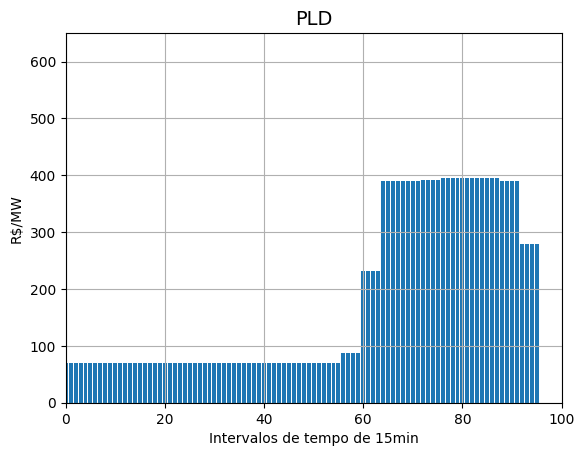

In [54]:
plt.bar(time, spot_price.Price)
plt.xlim((0.0, 100.0))
plt.ylim((0.0, 650.0))
plt.grid(True)


#Identificando os elementos do gráfico
plt.title('PLD', fontsize=14)  # Título do gráfico
plt.xlabel('Intervalos de tempo de 15min', fontsize=10)  # Título do eixo X
plt.ylabel('R$/MW', fontsize=10)  # Título do eixo Y
plt.show

In [55]:
# %%
model = pyo.ConcreteModel(name='H2V')

model.time_set = pyo.Set(initialize=time)

In [56]:
# Parâmetros de entrada
model.param_load = pyo.Param(model.time_set, initialize=load.pload.values, mutable=False)
model.param_pv_gen = pyo.Param(model.time_set, initialize=pv_gen.pgen.values, mutable=False)
model.param_spot_prices = pyo.Param(model.time_set, initialize=spot_price.Price, mutable=False)

In [57]:
# Parâmetros do módulo de armazenamento de eletricidade
model.max_elec_charge = pyo.Param(initialize=elec_storage_rate * elec_storage_size_wh)
model.max_elec_discharge = pyo.Param(initialize=elec_storage_rate * elec_storage_size_wh)
model.elec_storage_size = pyo.Param(initialize=elec_storage_size_wh)
model.elec_min_soc = pyo.Param(initialize=elec_storage_min_soc)
model.elec_max_soc = pyo.Param(initialize=elec_storage_max_soc)

In [58]:
# Parâmetros do módulo de armazenamento de H2
model.max_h2_charge = pyo.Param(initialize=h2_storage_rate * h2_storage_size_kg)
model.max_h2_discharge = pyo.Param(initialize=h2_storage_rate * h2_storage_size_kg)
model.h2_storage_size = pyo.Param(initialize=h2_storage_size_kg)
model.h2_min_soc = pyo.Param(initialize=h2_storage_min_soc)
model.h2_max_soc = pyo.Param(initialize=h2_storage_max_soc)

In [59]:
# Variáveis de compra/venda de energia
model.var_power_purchase = pyo.Var(model.time_set, domain=pyo.Reals)

In [60]:
# Variáveis de armazenamento de eletricidade
model.var_elec_charging = pyo.Var(time, within=pyo.Binary)
model.var_elec_discharging = pyo.Var(time, within=pyo.Binary)
model.var_elec_charge = pyo.Var(time,
                                initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                domain=pyo.NonNegativeReals)
model.var_elec_discharge = pyo.Var(time,
                                   initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                   domain=pyo.NonNegativeReals)
model.var_elec_soc = pyo.Var(time,
                             domain=pyo.NonNegativeReals,
                             bounds=(model.elec_min_soc, model.elec_max_soc))

In [61]:
# Variável de quantidade de eletricidade utilizada para produção de H2
model.var_elet_on_off = pyo.Var(time, within=pyo.Binary)

model.var_elec_to_h2_mass = pyo.Var(time,
                                    initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                    domain=pyo.NonNegativeReals)

In [62]:
# Variável de quantidade de massa de H2 produzida pelo eletrolisador 
model.var_h2_mass_from_elet = pyo.Var(time,
                                      initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                      domain=pyo.NonNegativeReals)

In [63]:
# Variável de quantidade de massa de H2 produzida pelo eletrolisador e destinada ao armazenamento
model.var_h2_mass_to_storage = pyo.Var(time,
                                       initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                       domain=pyo.NonNegativeReals)

In [64]:
# Variável de quantidade de massa de H2 proveniente do armazenamento para ??
model.var_h2_mass_from_storage = pyo.Var(time,
                                         initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                         domain=pyo.NonNegativeReals)

In [65]:
# Variável de quantidade de massa de H2 destinada à queima para produção de eletricidade
model.var_h2_mass_to_elec = pyo.Var(time,
                                       initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                       domain=pyo.NonNegativeReals)

In [66]:
# Variável de quantidade de massa de H2 destinada para  comercialização direta
model.var_h2_mass_to_market = pyo.Var(time,
                                      initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                      domain=pyo.NonNegativeReals)

model.var_gas_power_on_off = pyo.Var(time, domain=pyo.Binary)

model.var_gas_start_up = pyo.Var(time, domain=pyo.Binary)

model.var_gas_shut_down = pyo.Var(time, domain=pyo.Binary)

model.var_elec_from_gas = pyo.Var(time,
                                  initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                  domain=pyo.NonNegativeReals)

In [67]:
# TODO: model.var_gn_mass_to_plant

# Variáveis de armazenamento de H2
model.var_h2_charging = pyo.Var(time, within=pyo.Binary)
model.var_h2_discharging = pyo.Var(time, within=pyo.Binary)
model.var_h2_charge = pyo.Var(time,
                              initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                              domain=pyo.NonNegativeReals)
model.var_h2_discharge = pyo.Var(time,
                                 initialize={i: j for i, j in zip(time, np.zeros(len(time)))},
                                 domain=pyo.NonNegativeReals)
model.var_h2_soc = pyo.Var(time,
                           domain=pyo.NonNegativeReals,
                           bounds=(model.h2_min_soc, model.h2_max_soc))

Restrição de nível máximo de armazenamento:

$X_{nivel} < A_{max}$

In [68]:
# Restrição de conversão Eletricidade -> H2

def max_eletroliser_power(model, t):
    return model.var_elec_to_h2_mass[t] == max_elec_to_h2_power * model.var_elet_on_off[t]

model.max_eletroliser_power_constraint = pyo.Constraint(time, rule=max_eletroliser_power)

def elec_to_h2_constraint(model, t):
    return (model.var_h2_mass_from_elet[t] == 1.0 / tx_elec_to_h2 * model.var_elec_to_h2_mass[t] * 0.25)

model.elec_to_h2_constraint = pyo.Constraint(time, rule=elec_to_h2_constraint)

# Restrição de conversão H2 -> Eletricidade
def max_gas_power(model, t):
    return model.var_h2_mass_to_elec[t] == max_h2_to_elec_power * model.var_gas_power_on_off[t]

model.max_gas_power_constraint = pyo.Constraint(time, rule=max_gas_power)

In [69]:
# Restrição Liga-Desliga ao mesmo tempo
def start_up_shut_down_constraint(model, t):
    return model.var_gas_start_up[t] + model.var_gas_shut_down[t] <= 1

model.start_up_shut_down_constraint = pyo.Constraint(time, rule=start_up_shut_down_constraint)

In [70]:
# Restrição de causalidade entre estado da usina (ligado/desligado) e 
# instante de ligamento e instante de deligamento
def state_startup_shutdown(model, t):
    return model.var_gas_start_up[t] - model.var_gas_shut_down[t] == model.var_gas_power_on_off[t] - model.var_gas_power_on_off[t-1]
model.state_startup_shutdown_constraint = pyo.Constraint(time[1:], rule=state_startup_shutdown)

In [71]:
# Restrição de Tempo mínimo de funcionamento da usina
model.min_time_work_power_plant_constraint = pyo.ConstraintList()
time_window = np.arange(1, len(time) - min_uptime + 1)

for k in time_window:
    states = [model.var_gas_power_on_off[i] for i in range(k, k + min_uptime - 1)]
    model.min_time_work_power_plant_constraint.add(sum(states) >= min_uptime * model.var_gas_start_up[k])

In [72]:
# Restrição de Tempo mínimo de funcionamento da usina para a última janela de tempo 
model.last_min_time_work_power_plant_constraint = pyo.ConstraintList()
last_time_window = np.arange(len(time) - min_uptime + 2, len(time))
for k in last_time_window:
    states = [model.var_gas_power_on_off[i] - model.var_gas_start_up[k] for i in range(k, len(time))]
    model.last_min_time_work_power_plant_constraint.add(sum(states) >= 0.0)

In [73]:
# Restrição 
def h2_to_elec_constraint(model, t):
    return (model.var_elec_from_gas[t] == (1.0 / tx_h2_to_elec) * model.var_h2_mass_to_elec[t] * (1.0/0.25))
    
model.h2_to_elec_constraint = pyo.Constraint(time, rule=h2_to_elec_constraint)

In [74]:
# conexão eletrolisador com armazenamento de H2
def h2_mass_to_storage_constraint(model, t):
    return model.var_h2_charge[t] == model.var_h2_mass_to_storage[t]

model.h2_mass_to_storage_constraint = pyo.Constraint(time, rule=h2_mass_to_storage_constraint)

In [75]:
# conexão armazenamento de H2 com plata de geração e mercado de H2
def h2_mass_from_storage_constraint(model, t):
    return model.var_h2_discharge[t] == model.var_h2_mass_from_storage[t]

model.h2_mass_from_storage_constraint = pyo.Constraint(time, rule=h2_mass_from_storage_constraint)

In [76]:
# Restrição de Balanço de Potência Elétrica
def elec_power_balance_constraint(model, t):
    return (model.param_pv_gen[t] + model.var_elec_from_gas[t] + model.var_elec_discharge[t] + model.var_power_purchase[t] == model.var_elec_to_h2_mass[t] + model.param_load[t] + model.var_elec_charge[t])

model.elec_power_balance_constraint = pyo.Constraint(time, rule=elec_power_balance_constraint)

In [77]:
# Restrição de Balanço de Gás 1: Saída do Eletrolisador
def h2_mass_balance_constraint_1(model, t):
    return (model.var_h2_mass_to_storage[t] == model.var_h2_mass_from_elet[t])

model.h2_mass_balance_constraint_1 = pyo.Constraint(time, rule=h2_mass_balance_constraint_1)

In [78]:
# Restrição de Balanço de Gás 2: Saída do tanque de Armazenamento
def h2_mass_balance_constraint_2(model, t):
    return (model.var_h2_mass_from_storage[t] == model.var_h2_mass_to_elec[t] + model.var_h2_mass_to_market[t])

model.h2_mass_balance_constraint_2 = pyo.Constraint(time, rule=h2_mass_balance_constraint_2)

Restrições de armazenamento de eletricidade:

In [79]:
# restrição que impossibilita a bateria de carregar e descarregar ao mesmo tempo
def charging_discharging_elec_constraint(model, t):
    return model.var_elec_charging[t] + model.var_elec_discharging[t] <= 1

model.charge_discharge_elec_constraint = pyo.Constraint(time, rule=charging_discharging_elec_constraint)

# def charging_discharging_energy_constraint(model, t):
#     return model.var_elec_charge[t] * model.var_elec_discharge[t] == 0.0

# model.charge_discharge_energy_constraint = pyo.Constraint(time, rule=charging_discharging_energy_constraint)

####

In [80]:
# restrição de potência máxima de carga 
def max_charge_rate_constraint(model, t):
    return model.var_elec_charge[t] <= model.max_elec_charge

model.max_charge_rate_constraint = pyo.Constraint(time, rule=max_charge_rate_constraint)

In [81]:
# restrição de potência máxima de descarga
def max_discharge_rate_constraint(model, t):
    return model.var_elec_discharge[t] <= model.max_elec_discharge

model.max_discharge_rate_constraint = pyo.Constraint(time, rule=max_discharge_rate_constraint)

In [82]:
# restrição de carga inicial da bateria
model.init_soc_constraint = pyo.Constraint(expr=model.var_elec_soc[0] == 0.1 * elec_storage_size_wh)

In [83]:
# restrição que modela o armazenamento gradual do dispositivo
model.soc_memory_constraint = pyo.ConstraintList()
for t_m, t in zip(time[:-1], time[1:]):
    rule_ = (model.var_elec_soc[t] == model.var_elec_soc[t_m] + (model.var_elec_charge[t_m] - model.var_elec_discharge[t_m]) * 0.25)
    model.soc_memory_constraint.add(rule_)

Restrições de armazenamento de H2:

In [84]:
# restrição que impossibilita o tanque de carregar e descarregar ao mesmo tempo
def charging_discharging_h2_constraint(model, t):
    return model.var_h2_charging[t] + model.var_h2_discharging[t] <= 1

model.charge_discharge_h2_constraint = pyo.Constraint(time, rule=charging_discharging_h2_constraint)

# def charging_discharging_h2_constraint(model, t):
#     return model.var_h2_charge[t] * model.var_h2_discharge[t] == 0.0

# model.charge_discharge_h2_constraint = pyo.Constraint(time, rule=charging_discharging_h2_constraint)

In [85]:
# restrição de potência máxima de carga 
def max_h2_charge_rate_constraint(model, t):
    return model.var_h2_charge[t] <= model.max_h2_charge

model.max_h2_charge_rate_constraint = pyo.Constraint(time, rule=max_h2_charge_rate_constraint)

In [86]:
# restrição de potência máxima de descarga
def max_h2_discharge_rate_constraint(model, t):
    return model.var_h2_discharge[t] <= model.max_h2_discharge

model.max_h2_discharge_rate_constraint = pyo.Constraint(time, rule=max_h2_discharge_rate_constraint)

In [87]:
# restrição de carga inicial do armazenamento de h2
model.init_h2_soc_constraint = pyo.Constraint(expr=model.var_h2_soc[0] == 0.5 * h2_storage_size_kg) # ESSA LINHA É O CÓDIGO ORIGINAL - Alterado para 0 para impedir qualquer partida da usina sem gás
#model.init_h2_soc_constraint = pyo.Constraint(expr=model.var_h2_soc[0] == 0.00 * h2_storage_size_kg)

In [88]:
# TODO: Validar alteração da lógica de armazenamento de H
# restrição que modela o armazenamento gradual do dispositivo
model.h2_soc_memory_constraint = pyo.ConstraintList()
for t_m, t in zip(time[:-1], time[1:]):
    # rule_ = (model.var_h2_soc[t] == model.var_h2_soc[t_m] + (model.var_h2_charge[t_m] - model.var_h2_discharge[t_m]) * 0.25)
    rule_ = (model.var_h2_soc[t] == model.var_h2_soc[t_m] + (model.var_h2_charge[t_m] - model.var_h2_discharge[t_m]))
    model.h2_soc_memory_constraint.add(rule_)

Função objetivo:

In [89]:
# %%
# Função Objetivo
def obj_function(model):
    y = list() 
    for t in time:
        aux = model.param_spot_prices[t] * (-model.var_power_purchase[t]) + h2_price[t] * (model.var_h2_mass_to_market[t])
        y.append(aux)
    return sum(y)
model.cost_function = pyo.Objective(rule=obj_function, sense=pyo.maximize)

In [ ]:
solver = pyo.SolverFactory('cplex')
solver.solve(model)

Solving the model:

In [ ]:
# %%
# ----------------------------------
# Solving the model
# ----------------------------------
solver = pyo.SolverFactory('cplex')
results = solver.solve(model)
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print ("This is feasible and optimal")
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    print ("This is infeasible")
else:
    # something else is wrong
    print (str(results.solver))

Plotagens:

In [ ]:
# Análise de Resultados
pyo.value(model.cost_function)
plt.figure(figsize=(10, 6))#AUMENTA A FIGURA
# %%
elec_storage_discharge = np.array([i.value for i in model.var_elec_discharge.values()])
# %%
elec_storage_charge = np.array([i.value for i in model.var_elec_charge.values()])
# %%
elec_to_h2_mass = np.array([i.value for i in model.var_elec_to_h2_mass.values()])
# %%
elec_from_gas = np.array([i.value for i in model.var_elec_from_gas.values()])
# %%
power_to_purchase = np.array([i.value for i in model.var_power_purchase.values()])
power_buy= np.array([i if i > 0.0 else 0.0 for i in power_to_purchase])
power_sell = np.array([-i if i < 0.0 else 0.0 for i in power_to_purchase])
plt.bar(time, power_to_purchase)
# %%
soc_elec = np.array([i.value for i in model.var_elec_soc.values()])
plt.bar(time, soc_elec)
# %%
soc_h2 = np.array([i.value for i in model.var_h2_soc.values()])
plt.bar(time, soc_h2)
# %%
power_plant = np.array([i.value for i in model.var_elec_from_gas.values()])
plt.bar(time, power_plant)
# %%
h2_to_market = np.array([i.value for i in model.var_h2_mass_to_market.values()])
plt.bar(time, h2_to_market)

# %%
#plt.figure(figsize=(10, 6))  INTERESSANTE: AO INSERIR ESTA LINHA DOIS GRÁFICOS SURGEM, OU SEJA OS COMANDOS ACIMA CRIAM UM GRÁFICO E ABAIXO CONTINUA A CRIAÇÃO, SOBREPONDO-OS
plt.bar(time, load.pload.values)
plt.bar(time, elec_storage_charge, bottom=load.pload.values)
plt.bar(time, elec_to_h2_mass, bottom=load.pload.values+elec_storage_charge)
plt.bar(time, power_sell, bottom=load.pload.values+elec_storage_charge+elec_to_h2_mass)
plt.bar(time, -pv_gen.pgen.values)
plt.bar(time, -elec_storage_discharge, bottom=-pv_gen.pgen.values)
plt.bar(time, -elec_from_gas, bottom=-elec_storage_discharge-pv_gen.pgen.values)
plt.bar(time, -power_buy, bottom=-elec_storage_discharge-pv_gen.pgen.values-elec_from_gas)
plt.legend(['load', 'storage-charge', 'power-2-h2', 'power-sell', 'pv-gen', 'storage-discharge', 'h2-2-power', 'power-buy'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

CARGA E DESCARGA DO BESS

In [ ]:
plt.bar(time, -elec_storage_charge, color='cyan', label='Carga da bateria')
plt.bar(time, elec_storage_discharge, color='magenta', label='Descarga da bateria')


In [ ]:
#import matplotlib.pyplot as plt

# Criar a figura com fundo branco
fig, ax1 = plt.subplots(figsize=(10, 6), facecolor='white')

# Plotar os gráficos com cores diferenciadas
ax1.bar(time, -load.pload.values, color='blue', label='Carga')
ax1.bar(time, -elec_to_h2_mass, bottom=-load.pload.values, color='#90EE90', label='Energia para produção de H2V')
ax1.bar(time, power_sell, color='cyan', label='Energia vendida')
ax1.bar(time, power_buy, color='red', label='Energia comprada')
ax1.bar(time, pv_gen.pgen.values, color='green', label='Geração solar')
ax1.bar(time, elec_from_gas, color='gray', label='Geração Termelétrica')
ax1.bar(time, 100*elec_storage_charge, bottom=elec_to_h2_mass+power_sell-power_buy, color='orange', label='Carga da bateria')
ax1.bar(time, 100*elec_storage_discharge, bottom=pv_gen.pgen.values + elec_from_gas + power_buy, color='purple', label='Descarga da bateria')
# Criar um segundo eixo y
ax2 = ax1.twinx()

# Plotar o eixo secundário
#ax2.step(time, -elec_storage_charge, color='orange', label='Carga da bateria', where='mid')
#ax2.step(time, elec_storage_discharge, color='purple', label='Descarga da bateria', where='mid')

# Definir os rótulos dos eixos e título
# ax1.set_xlabel('Horário do Dia (Intervalos de 15 Minutos)', fontsize=10, color='black')
# ax1.set_ylabel('Valores de Potência e Carga (W/Wh/Wp)', fontsize=10, color='black')
# ax2.set_ylabel('Armazenamento de Energia (Wh)', fontsize=10, color='black')

# Ajustar as cores das legendas e da grade
ax1.legend(fontsize=6, loc='upper left')
ax2.legend(fontsize=6, loc='upper right')
ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Ajustar a cor dos ticks
ax1.tick_params(colors='black', which='both')
ax2.tick_params(colors='black', which='both')

# Reposicionar a legenda para fora do gráfico
fig.tight_layout()
fig.subplots_adjust(right=0.75)  # Ajusta a posição do gráfico para acomodar a legenda

# Exibir o gráfico
plt.show()


In [ ]:
# Definindo o fundo como branco (removendo transparência)
plt.gcf().set_facecolor('white')

# Crie a figura e os eixos
fig, ax1 = plt.subplots(figsize=(10, 6), facecolor='white')

# Plotando as barras de Energia comercializada e Energia para produção de H2V no eixo primário
plt.bar(time, -load.pload.values, label='Carga', color='blue')
plt.bar(time, pv_gen.pgen.values, label='Geração solar', color='green')
ax1.bar(time, -power_sell, bottom=-load.pload.values-elec_to_h2_mass, label='Energia vendida', color='brown')
ax1.bar(time, -elec_to_h2_mass, bottom=-load.pload.values-power_sell, label='Energia para produção de H₂V', color='red')
ax1.bar(time, power_buy, bottom=pv_gen.pgen.values, label='Energia comprada no grid', color='orange')
ax1.bar(time, elec_storage_charge, color='cyan', label='Carga da bateria')
ax1.bar(time, -elec_storage_discharge, color='magenta', label='Descarga da bateria')
ax1.bar(time, power_plant, label='Geração UTE', color='gray')

# Configurações dos eixos e legenda
ax1.set_xlabel('Hora do dia (96 intervalos de 15 Minutos)', fontsize=12)
ax1.set_ylabel('Balanço energético', fontsize=12)
ax1.grid(True, linestyle='--', linewidth=0.5)

# Criando um segundo eixo y para o PLD (Preço Spot)
ax2 = ax1.twinx()
ax2.plot(time, spot_price.Price, color='purple', label='PLD', marker='.')
ax2.set_ylabel('PLD (R$/MW)', fontsize=12)

# Posicionando a legenda na parte inferior e distribuindo horizontalmente
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Ajustando o layout para acomodar a legenda
plt.tight_layout()

# Salvando o gráfico no formato EPS, sem transparência e com o texto como curvas
#plt.savefig('Cen_1a6_balan.eps', format='eps', transparent=False)

# Mostra o gráfico na tela
plt.show()

In [ ]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
# Definindo o fundo como branco (removendo transparência)
plt.gcf().set_facecolor('white')

# Função para formatar o eixo y em milhões
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)  # Converte para milhões e formata com 1 casa decimal

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10), facecolor='white')


# Gráfico 1: Preço do hidrogênio e PLD
ax1.step(time, spot_price, color='purple', label='PLD', marker='.')#where='mid', linestyle='dotted', linewidth=2)
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Formatar o eixo x como HH:MM
ax1.set_xticklabels([])  # Remove os rótulos do eixo x para evitar sobreposição
ax1.set_ylabel('PLD(R$/MW)', fontsize=12)

# Criando um segundo eixo y para o preço do hidrogênio
ax1_2 = ax1.twinx()
ax1_2.step(time, h2_price, color='blue', label='Preço do H₂V')#, where='mid', linestyle='solid', linewidth=2)
ax1_2.set_ylabel('Preço do H₂V (R$/kg)', fontsize=12)

# Ajustar as legendas dos dois eixos y
ax1.legend(loc='upper left', fontsize=12)
ax1_2.legend(loc='lower right', fontsize=12)


# Gráfico 2: Nível de carga da bateria
ax2.step(time, soc_elec, color='orange', label='Capacidade do BESS', where='mid', linestyle='-', linewidth=2)
ax2.set_ylabel('Wh', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.set_xticklabels([])  # Remove os rótulos do eixo x para evitar sobreposição

# Gráfico 3: Nível do tanque de hidrogênio e h2_to_market
ax3.step(time, soc_h2, color='green', label='Estoque de H₂V', where='mid', linestyle='-', linewidth=2)
ax3.set_ylabel('kg', fontsize=12)
ax3.legend(loc='upper left', fontsize=12)
ax3.grid(True, linestyle='--', linewidth=0.5)

# Criando um segundo eixo y para h2_to_market
ax3b = ax3.twinx()
ax3b.step(time, h2_to_market, color='red', label='H₂V comercializado')#, where='mid', linestyle='dotted', linewidth=2)
ax3b.set_ylabel('kg', fontsize=12)
#x3b.legend(loc='upper right', fontsize=12)

# Gráfico 4: Comercialização de Energia e Geração Termelétrica
ax4.bar(time, -load.pload.values, label='Carga', color='blue')  # OK
ax4.bar(time, pv_gen.pgen.values, label='Geração solar', color='green')
ax4.bar(time, -power_sell, bottom=-load.pload.values-elec_to_h2_mass, label='Energia vendida', color='brown')
ax4.bar(time, -elec_to_h2_mass, bottom=-load.pload.values-power_sell, label='Energia para produção de H₂V', color='red')
ax4.bar(time, power_buy, bottom=pv_gen.pgen.values, label='Energia comprada no grid', color='orange')
ax4.bar(time, power_plant, label='Geração UTE', color='gray')

ax4.set_xlabel('Hora do dia (96 intervalos de 15 Minutos)', fontsize=12)
ax4.set_ylabel('Balanço energético', fontsize=12)
ax4.grid(True)

# Criando um segundo eixo y para o PLD (Preço Spot)
ax5 = ax4.twinx()
ax5.plot(time, spot_price.Price, color='purple', label='PLD', marker='.')
ax5.set_ylabel('PLD (R$/MW)', fontsize=12)

# Legendas separadas
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)  # Ajuste ncol conforme necessário
ax5.legend(loc='lower right', fontsize=12)

# Melhorar o layout e ajustar os espaçamentos
fig.tight_layout()

# Salvando o gráfico no formato EPS, sem transparência e com o texto como curvas
#plt.savefig('Cen_1_multi_graph.eps', format='eps', transparent=False)

# Mostra o gráfico na tela
plt.show()


In [ ]:
# Definindo o fundo como branco (removendo transparência)
plt.gcf().set_facecolor('white')

# Ajustando o layout para múltiplos gráficos
fig, axs = plt.subplots(2, 2, figsize=(14, 10), facecolor='white')  # Layout em grade 2x2

# Gráfico 1: Preço do hidrogênio e PLD
ax1 = axs[0, 0]
ax1.step(time, spot_price, color='purple', label='PLD', marker='.', linewidth=2)
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.set_xlabel('Hora do dia (96 intervalos de 15 Minutos)', fontsize=12)
ax1.set_ylabel('PLD (R$/MW)', fontsize=10)
#plt.ylim(100, 500)  # Define os valores mínimo e máximo para o eixo y
ax1.tick_params(axis='y', labelsize=10)

# Segundo eixo y para o preço do hidrogênio
ax1_2 = ax1.twinx()
ax1_2.step(time, h2_price, color='blue', label='Preço do H₂V', linewidth=2)
plt.ylim(h2_price_start-10, h2_price_end+10)  # Define os valores mínimo e máximo para o eixo y
ax1_2.set_ylabel('LCOH (R$/kg)', fontsize=10)
ax1_2.tick_params(axis='y', labelsize=10)

# Legenda centralizada (ax1 e ax1_2)
legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(0.1, 1.15), fontsize=10)
legend2 = ax1_2.legend(loc='upper left', bbox_to_anchor=(0.5, 1.15), fontsize=10)  # Horizontal
legend1.get_frame().set_linewidth(0)
legend2.get_frame().set_linewidth(0)

# Gráfico 2: Estoque de H₂V e H₂ comercializado em eixos diferentes
ax2 = axs[0, 1]
ax2.step(time, soc_h2, color='green', label='Estoque de H₂V', where='mid', linestyle='-', linewidth=2)#, marker='o', markersize=5)
ax2.set_ylabel('Estoque (kg)', fontsize=10)
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.set_xlabel('Hora do dia (96 intervalos de 15 Minutos)', fontsize=10)

# Criando um segundo eixo y para h2_to_market
ax2_2 = ax2.twinx()
ax2_2.step(time, h2_to_market, color='red', label='H₂V Comercializado', where='mid', linestyle='-', linewidth=2)#, marker='D', markersize=5)
ax2_2.set_ylabel('Comercialização (kg)', fontsize=10)

# Legendas dos eixos (ax2 e ax2_2)
legend3 = ax2.legend(loc='upper left', bbox_to_anchor=(0.1, 1.15), fontsize=10)
legend4 = ax2_2.legend(loc='upper left', bbox_to_anchor=(0.5, 1.15), fontsize=10)  # Horizontal
legend3.get_frame().set_linewidth(0)
legend4.get_frame().set_linewidth(0)

# Gráfico 3: Comercialização de Energia e Geração Termelétrica
ax3 = axs[1, 0]
ax3.bar(time, -load.pload.values, label='Carga', color='blue')  # OK
ax3.bar(time, pv_gen.pgen.values, label='Geração Solar', color='green')
ax3.bar(time, -power_sell, bottom=-load.pload.values-elec_to_h2_mass, label='Energia Vendida', color='brown')
ax3.bar(time, -elec_to_h2_mass, bottom=-load.pload.values-power_sell, label='Energia para Produção de H₂V', color='red')
ax3.bar(time, power_buy, bottom=pv_gen.pgen.values, label='Energia Comprada no Grid', color='orange')
ax3.bar(time, power_plant, label='Geração UTE', color='gray')

ax3.set_xlabel('Hora do dia (96 intervalos de 15 Minutos)', fontsize=10)
ax3.set_ylabel('Balanço Energético (Wh)', fontsize=10)
ax3.grid(True, linestyle='--', linewidth=0.5)
ax3.tick_params(axis='x', labelsize=10)
ax3.tick_params(axis='y', labelsize=10)

# Ajustando a legenda (ax3)
legend5 = ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=10)  # Legendas centralizadas
legend5.get_frame().set_linewidth(0)  # Remover borda da legenda

# Gráfico 4: Nível de carga da bateria (BESS)
ax4 = axs[1, 1]
ax4.bar(time, -elec_storage_charge, color='cyan', label='Carga do BESS')  # Carga da bateria (negativo)
ax4.bar(time, elec_storage_discharge, color='magenta', label='Descarga do BESS')  # Descarga da bateria (positivo)
ax4.set_ylabel('Energia (Wh)', fontsize=10)
ax4.grid(True, linestyle='--', linewidth=0.5)
ax4.set_xlabel('Hora do dia (96 intervalos de 15 Minutos)', fontsize=10)

# Legenda centralizada (ax4)
legend6 = ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=10)  # Legendas centralizadas
legend6.get_frame().set_linewidth(0)  # Remover borda da legenda

# Ajustar o layout geral para evitar sobreposição
fig.tight_layout(pad=1.0)  # Ajuste do padding para reduzir o espaço entre os gráficos

# Salvando o gráfico no formato EPS, sem transparência e com o texto como curvas
#plt.savefig('Cen_6_de_6.eps', format='eps', transparent=False)

# Mostra o gráfico na tela
plt.show()


In [ ]:
# Define o período em horas (exemplo de uma hora)
periodo_horas = 1

# Calcula o total de potência comprada e vendida em MWh
total_power_buy_mwh = np.sum(power_buy) / 1000000 * periodo_horas
total_power_sell_mwh = np.sum(power_sell) / 1000000 * periodo_horas
total_elec_from_gas_mwh = np.sum(elec_from_gas) / 1000000 * periodo_horas
total_elec_to_h2_mwh = np.sum(elec_to_h2_mass) / 1000000 * periodo_horas

print("Total de Potência Comprada (MWh):", total_power_buy_mwh)
print("Total de Potência Vendida (MWh):", total_power_sell_mwh)
print("Total de Potência Gerada na UTE (MWh):", total_elec_from_gas_mwh)
print("Massa total de H2 produzida (kg):", total_elec_to_h2_mwh)


In [ ]:
model.solver